In [1]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
import probeinterface as pi
from pathlib import Path

global_job_kwargs = dict(n_jobs=4, chunk_duration="1s",progress_bar=True)
si.set_global_job_kwargs(**global_job_kwargs)


basefolder='D:/DataKoen/Koen_Junli_optoelectrode_MLA-024623_03072024_g0/Koen_Junli_optoelectrode_MLA-024623_03072024_g0_imec0'



recording =  si.read_spikeglx(basefolder, stream_name='imec0.ap', load_sync_channel=False)

print(recording)






SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 66,465,367 samples 
                            2,215.52s (36.93 minutes) - int16 dtype - 47.54 GiB


(-150.0, 200.0)

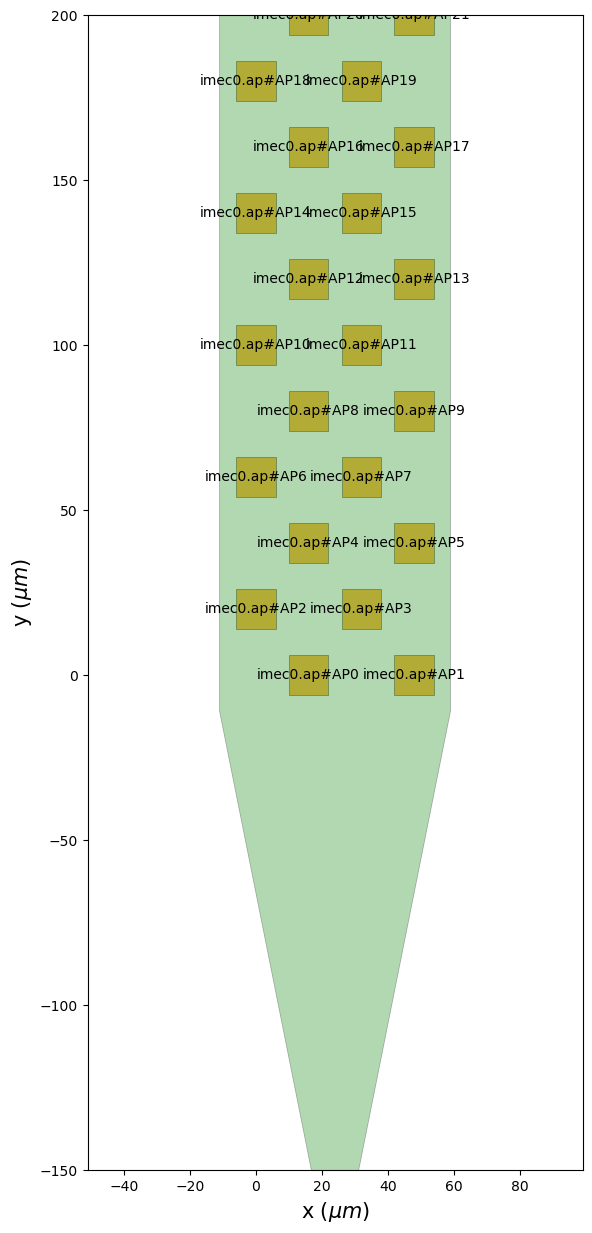

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
si.plot_probe_map(recording, ax=ax, with_channel_ids=True)
ax.set_ylim(-150, 200)

In [28]:
rec1 = si.highpass_filter(recording, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
print(bad_channel_ids)
rec1 = si.interpolate_bad_channels(recording=rec1, bad_channel_ids=bad_channel_ids)
rec1 = si.phase_shift(rec1)
rec1 = si.common_reference(rec1, operator="median", reference="global")





['imec0.ap#AP191']


In [65]:


event =  si.read_spikeglx(basefolder, stream_name='nidq')
channel_ids = event.channel_ids
digital_signals = event.get_traces()  # Assuming digital channels are last
print(digital_signals.shape)
print(channel_ids)

def extract_ttl_events(digital_signal, sampling_rate):
    # Find the indices where there are rising edges in the digital signal
    # A TTL event is indicated by a transition from 0 to 1 in the signal
    ttl_rising_edges = np.where(np.diff(digital_signal > 0.5, axis=0) > 0)[0]
    
    # Convert sample indices to timestamps
    ttl_timestamps = ttl_rising_edges / sampling_rate
    return ttl_timestamps

# Get the sampling rate of the recording
sampling_rate = recording.get_sampling_frequency()

# Extract TTL event timestamps from the first digital channel
ttl_event_timestamps = extract_ttl_events(digital_signals[:, 0], sampling_rate)

# Print the timestamps of TTL events
print(f"Extracted TTL event timestamps: {ttl_event_timestamps}")

ttl_event_timestamps[1:100]

np.unique(digital_signals)


(23469643, 1)
['nidq#XD0']
Extracted TTL event timestamps: [2.26667206e-02 1.99233808e-01 3.75767561e-01 ... 7.81809961e+02
 7.81986529e+02 7.82163062e+02]


array([0, 1, 2, 3], dtype=int16)

In [63]:
event =  si.read_spikeglx(basefolder, stream_name='nidq', load_sync_channel=False)
event2 =si.read_spikeglx_event(folder_path='D:/DataKoen/Koen_Junli_optoelectrode_MLA-024623_03072024_g0')
event3 =si.read_spikeglx_event(folder_path='D:/DataKoen/Koen_Junli_optoelectrode_MLA-024623_03072024_g0/Koen_Junli_optoelectrode_MLA-024623_03072024_g0_imec0/Koen_Junli_optoelectrode_MLA-024623_03072024_g0_t0.nidq.bin')
print(event)
print(event2)
print(event3)

event2

SpikeGLXRecordingExtractor: 1 channels - 10.6kHz - 1 segments - 23,469,643 samples 
                            2,215.52s (36.93 minutes) - int16 dtype - 44.76 MiB
SpikeGLXEventExtractor: 0 channels - 1 segments
SpikeGLXEventExtractor: 0 channels - 0 segments


SpikeGLXEventExtractor: 0 channels - 1 segments

In [66]:
lfp =  si.read_spikeglx(basefolder, stream_name='nidq', load_sync_channel=False)
%matplotlib widget
si.plot_traces({'filter':lfp}, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [2]:

basefolder =  "D:/neurojelte"

recording =  si.read_spikeglx(basefolder, stream_name='nidq', load_sync_channel=False)

# Extract the digital signals from the recording
# Digital signals may be in the last channels or specific channel indices
# Adjust as necessary depending on your dataset
digital_signals = recording.get_traces()

digital_word = digital_signals[:, 0]  # Assuming single digital word for all channels

# Define the bit you want to extract TTL from (e.g., bit 3)
bit = 1

# Function to extract TTL pulses from the specific bit in the word
def extract_ttl_from_bit(digital_word, bit, sampling_rate):
    """
    Extracts TTL events from a specific bit in the digital signal word.
    
    digital_word: 1D array of digital signals (each value is a 16-bit word).
    bit: The bit in the word representing the TTL signal.
    sampling_rate: Sampling rate of the recording.
    
    Returns:
    ttl_timestamps: Timestamps of the detected TTL pulses (rising edges).
    """
    # Extract the specific bit from the word (bit-shifting and masking)
    ttl_signal = (digital_word >> bit) & 1  # Right shift and mask to isolate the specific bit
    
    # Detect rising edges (0 -> 1 transitions)
    ttl_rising_edges = np.where(np.diff(ttl_signal) > 0)[0]
    
    # Convert sample indices to timestamps (in seconds)
    ttl_timestamps = ttl_rising_edges / sampling_rate
    
    return ttl_timestamps

# Get the sampling rate of the recording
sampling_rate = recording.get_sampling_frequency()

# Extract TTL event timestamps from the bit 3 of the digital word
ttl_event_timestamps = extract_ttl_from_bit(digital_word, bit, sampling_rate)

# Print the extracted TTL event timestamps
print(f"Extracted TTL event timestamps: {ttl_event_timestamps}")
print(ttl_event_timestamps[:10])

Extracted TTL event timestamps: [  30.64407663   39.5926545    51.41446265   57.1365682    67.44392902
   79.58282429  126.46517846  137.99010093  148.46086687  272.84463604
  290.7384878   372.48050637  420.31034591  466.45732984  473.45052144
  480.17741272  489.01478825  503.45570388  530.99725443  574.47387209
  579.19931025  590.66126842  599.26859297  653.23136364  689.38986746
  706.33595065  714.87011576  727.99255692  758.23335991  773.86427261
  783.90523872  791.33795326  799.45090888  812.08955383  816.8142368
  865.734199    887.85204006  898.41390128  941.24124083  980.01894652
 1035.30264604 1084.36798311 1095.63028684 1116.6243991  1124.35069535
 1132.71210982 1144.64200512 1157.36211663 1164.3074478  1170.03323492
 1174.75914509 1183.65193299 1191.37936203 1199.10565828 1207.83220908
 1225.34034547 1235.06828363 1245.53942716 1253.9812698  1262.70621582
 1268.43304134 1276.15952638 1280.88581414 1292.81174467 1303.79160582
 1309.51777054 1317.24368919 1325.9705232  133

In [ ]:
from spikeinterface.sorters import installed_sorters
installed_sorters()

Sorting_KS4 = si.run_sorter(sorter_name="kilosort4", recording=rec1, folder=basefolder + str('/sorted'),remove_existing_folder=True)

C:\Users\deepl\AppData\Local\Temp\ipykernel_15904\230298042.py:4: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  Sorting_KS4 = si.run_sorter(sorter_name="kilosort4", recording=rec1, output_folder=basefolder + str('/sorted'),remove_existing_folder=True)


Loading recording with SpikeInterface...
number of samples: 66465367
number of channels: 384
numbef of segments: 1
sampling rate: 29999.928571428572
dtype: int16
Preprocessing filters computed in  295.53s; total  295.53s

computing drift
Re-computing universal templates from data.


C:\Users\deepl\anaconda3\envs\si_env\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
 11%|█▏        | 125/1108 [14:22<1:55:51,  7.07s/it]